<center>
<h4>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación</h4>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones</h3>
</center>

<h1> Práctico </h1>
<h3> Análisis y Visualización de Datos - 2020 </h3>

Durante este práctico vamos a trabajar sobre el dataset [Human Freedom Index 2018](https://www.cato.org/human-freedom-index-new) de el instituto Cato. Este índice mide en detalle lo que entendemos como libertad, utilizando 79 indicadores de libertad personal y económica en distintos aspectos, hasta obtener un hermoso numerito del 1 al 10.

Las variables más importantes sobre las que trabaja el dataset son:

* Rule of Law
* Security and Safety
* Movement
* Religion
* Association, Assembly, and Civil Society
* Expression and Information
* Identity and Relationships
* Size of Government
* Legal System and Property Rights
* Access to Sound Money
* Freedom to Trade Internationally
* Regulation of Credit, Labor, and Business

Nosotros centrarermos nuestro análisis en variables relacionadas a *Identity and Relationships* en paises de Latinoamérica, y los compararemos con las estadísticas globales. La pregunta a responder es simple: **¿Qué niveles de libertad se viven en Latinoamérica, especificamente en cuanto libertades de indentidad?**. Sin embargo, para hacer un análisis de los datos tenemos que platear también estas sub preguntas:

1. ¿Qué significa tener un puntaje de 4.5? Hay que poner los puntajes de la región en contexto con los datos del resto del mundo.
2. ¿Cuál es la tendencia a lo largo de los años? ¿Estamos mejorando, empeorando?
3. En este estudio, la libertad se mide con un estimadores principal: *hf_score* que hace referencia a Human Freedom, que a su vez está calculado en base a dos otros estimadores *ef_score*, para Economic Freedom y *pf_score*, para Personal Freedom. Estos tres estimadores, ¿se relacionan de la misma manera con la libertad de identidad?

Inicialmente, en toda exploración de datos tenemos muy poca información a priori sobre el significado de los datos y tenemos que empezar por comprenderlos. Les proponemos los siguientes ejercicios como guía para comenzar esta exploración.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from scipy import stats

In [2]:
sns.__version__

'0.10.1'

In [3]:
sns.set(style="whitegrid")

Si un archivo está disponible en la web, podemos leerlo con pandas utilizando su URL sin necesidad de descargarlo.

In [4]:
dataset = pd.read_csv(
    'https://object.cato.org/sites/cato.org/files/human-freedom-index-files/human-freedom-index-2019.csv')
dataset.shape

(1620, 120)

In [5]:
dataset.columns  # Way too many columns!

Index(['year', 'ISO_code', 'countries', 'region', 'hf_score', 'hf_rank',
       'hf_quartile', 'pf_rol_procedural', 'pf_rol_civil', 'pf_rol_criminal',
       ...
       'ef_regulation_business_adm', 'ef_regulation_business_bureaucracy',
       'ef_regulation_business_start', 'ef_regulation_business_bribes',
       'ef_regulation_business_licensing', 'ef_regulation_business_compliance',
       'ef_regulation_business', 'ef_regulation', 'ef_score', 'ef_rank'],
      dtype='object', length=120)

Por suerte las columnas tienen un prefijo que nos ayuda a identificar a qué sección pertenecen. Nos quedamos sólo con las que comienzan con *pf_indentity*, junto con otras columnas más generales

In [6]:
score_cols = [col for col in dataset.columns if 'pf_identity' in col] + [
    'pf_score', # Personal Freedom (score)
    'pf_rank', # Personal Freedom (rank)
    'ef_score', # Economic Freedom (score)
    'ef_rank', # Economic Freedom (rank)
    'hf_score', # Human Freedom (score)
    'hf_rank', # Human Freedom (rank)
]

important_cols = ['year', 'ISO_code', 'countries', 'region'] + score_cols

In [7]:
dataset[important_cols]

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank
0,2017,ALB,Albania,Eastern Europe,0,10,10,10,7.5,5.8,8.01,46,7.67,30,7.84,38
1,2017,DZA,Algeria,Middle East & North Africa,-,0,0,0,0,0,5.2,146,4.77,159,4.99,155
2,2017,AGO,Angola,Sub-Saharan Africa,10,0,0,0,5,5,5.98,121,4.83,158,5.4,151
3,2017,ARG,Argentina,Latin America & the Caribbean,10,10,10,10,10,10,8.04,41,5.67,147,6.86,77
4,2017,ARM,Armenia,Caucasus & Central Asia,7,10,10,10,7.5,8.2,7.15,72,7.7,27,7.42,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,2008,AUS,Australia,Oceania,-,10,10,10,10,10,9.29,7,8.18,6,8.73,4
1616,2008,DNK,Denmark,Western Europe,-,10,10,10,10,10,9.49,3,7.98,9,8.73,4
1617,2008,CHE,Switzerland,Western Europe,-,10,10,10,10,10,9.31,6,8.35,4,8.83,3
1618,2008,NZL,New Zealand,Oceania,-,10,10,10,10,10,9.42,4,8.46,3,8.94,2


Si analizamos los tipos, vemos que casi todas las columnas se leen como objetos debido a que los valores nulos están marcados con `-`. Los vamos a eliminar y volveremos a convertir las columnas con puntajes a tipo numérico.

In [8]:
dataset.dtypes

year                                  int64
ISO_code                             object
countries                            object
region                               object
hf_score                             object
                                      ...  
ef_regulation_business_compliance    object
ef_regulation_business               object
ef_regulation                        object
ef_score                             object
ef_rank                              object
Length: 120, dtype: object

In [9]:
dataset = dataset[important_cols].replace('-', np.nan)
for score_col in score_cols:
  dataset[score_col] = pd.to_numeric(dataset[score_col])
dataset

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank
0,2017,ALB,Albania,Eastern Europe,0.0,10.0,10.0,10.0,7.5,5.8,8.01,46.0,7.67,30.0,7.84,38.0
1,2017,DZA,Algeria,Middle East & North Africa,NaN,0.0,0.0,0.0,0.0,0.0,5.20,146.0,4.77,159.0,4.99,155.0
2,2017,AGO,Angola,Sub-Saharan Africa,10.0,0.0,0.0,0.0,5.0,5.0,5.98,121.0,4.83,158.0,5.40,151.0
3,2017,ARG,Argentina,Latin America & the Caribbean,10.0,10.0,10.0,10.0,10.0,10.0,8.04,41.0,5.67,147.0,6.86,77.0
4,2017,ARM,Armenia,Caucasus & Central Asia,7.0,10.0,10.0,10.0,7.5,8.2,7.15,72.0,7.70,27.0,7.42,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,2008,AUS,Australia,Oceania,NaN,10.0,10.0,10.0,10.0,10.0,9.29,7.0,8.18,6.0,8.73,4.0
1616,2008,DNK,Denmark,Western Europe,NaN,10.0,10.0,10.0,10.0,10.0,9.49,3.0,7.98,9.0,8.73,4.0
1617,2008,CHE,Switzerland,Western Europe,NaN,10.0,10.0,10.0,10.0,10.0,9.31,6.0,8.35,4.0,8.83,3.0
1618,2008,NZL,New Zealand,Oceania,NaN,10.0,10.0,10.0,10.0,10.0,9.42,4.0,8.46,3.0,8.94,2.0


### Dataset Latin America & the Caribbean

In [10]:
dataset_la = dataset[dataset.region == 'Latin America & the Caribbean']
dataset_la.head()

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank
3,2017,ARG,Argentina,Latin America & the Caribbean,10.0,10.0,10.0,10.0,10.0,10.0,8.04,41.0,5.67,147.0,6.86,77.0
8,2017,BHS,Bahamas,Latin America & the Caribbean,NaN,10.0,10.0,10.0,10.0,10.0,7.87,48.0,7.25,58.0,7.56,48.0
11,2017,BRD,Barbados,Latin America & the Caribbean,NaN,0.0,0.0,0.0,10.0,5.0,7.59,57.0,6.45,112.0,7.02,66.0
14,2017,BLZ,Belize,Latin America & the Caribbean,NaN,10.0,10.0,10.0,10.0,10.0,7.12,74.0,6.78,85.0,6.95,68.0
17,2017,BOL,Bolivia,Latin America & the Caribbean,10.0,10.0,10.0,10.0,10.0,10.0,7.07,75.0,6.14,126.0,6.61,97.0


# Parte 1

Luego de las clases del primer fin de semana, ya tenemos las herramientas para responder las siguientes preguntas:

## 1. Estadísticos descriptivos

  1. Para comenzar con un pantallazo de los datos, calcular el rango de las variables.
  3. Para cada país, tenemos varias realizaciones para cada variable *pf_identity* y *hf_score*. Si queremos comparar un país con otro, ¿cuál es la manera adecuada de hacerlo? Por ejemplo, ¿nos quedamos con un único valor? ¿o comparamos todos los valores? ¿usamos el promedio? ¿usamos la mediana? 
  2. Obtener media, mediana y desviación estándar de las variables *pf_identity* y *hf_score* en el mundo y compararla con la de Latinoamérica y el caribe. Usar la respuesta del punto anterior para justificar si la comparación es válida o no.
  3. ¿Tiene sentido calcular la moda?
  4. ¿Cómo pueden sanearse los valores faltantes?
  5. ¿Encuentra outliers en estas dos variables? ¿Qué método utiliza para detectarlos? Los outliers, ¿son globales o por grupo? ¿Los eliminaría del conjunto de datos?
  
  

### Rango de Variables

Calculamos rango de variables para Latinoamerica y para todo el mundo.

#### Latin America & the Caribbean

In [11]:
dataset_la.describe().reset_index()

,index,year,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank
0,count,260.000000,60.000000,258.000000,258.000000,258.000000,248.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000
1,mean,2012.500000,3.966667,8.023256,9.224806,8.624031,9.455645,8.582171,7.348333,70.546512,6.725271,79.170543,7.036977,71.918605
2,std,2.877821,4.786870,3.990192,2.679335,2.982785,1.494270,1.875832,0.633831,21.876016,0.896733,35.990298,0.634897,25.144817
3,min,2008.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.200000,5.030000,27.000000,2.580000,10.000000,3.800000,25.000000
4,25%,2010.000000,0.000000,10.000000,10.000000,10.000000,10.000000,6.850000,6.932500,53.250000,6.432500,51.000000,6.762500,55.250000
5,50%,2012.500000,0.000000,10.000000,10.000000,10.000000,10.000000,10.000000,7.290000,71.500000,6.905000,78.000000,7.020000,69.000000
6,75%,2015.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,7.770000,85.000000,7.287500,105.500000,7.377500,87.000000
7,max,2017.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,8.820000,149.000000,7.930000,162.000000,8.180000,161.000000


In [12]:
print("El rango de la columna:")
for column in dataset_la.columns:
    if(dataset_la[column].dtype != np.object):
        minor = dataset_la[column].min()
        maximum = dataset_la[column].max() 
        phrase = "\t\t\t{} es de {} a {}".format(column, minor, maximum)  
        print(phrase) 

El rango de la columna:
			year es de 2008 a 2017
			pf_identity_legal es de 0.0 a 10.0
			pf_identity_sex_male es de 0.0 a 10.0
			pf_identity_sex_female es de 0.0 a 10.0
			pf_identity_sex es de 0.0 a 10.0
			pf_identity_divorce es de 0.0 a 10.0
			pf_identity es de 4.2 a 10.0
			pf_score es de 5.03 a 8.82
			pf_rank es de 27.0 a 149.0
			ef_score es de 2.58 a 7.93
			ef_rank es de 10.0 a 162.0
			hf_score es de 3.8 a 8.18
			hf_rank es de 25.0 a 161.0


#### World

In [13]:
dataset.describe().reset_index()

,index,year,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank
0,count,1620.000000,308.000000,1537.000000,1540.000000,1540.000000,1519.000000,1540.000000,1540.000000,1540.000000,1540.000000,1540.000000,1540.000000,1540.000000
1,mean,2012.500000,6.379870,6.701366,7.922078,7.314935,7.485188,7.280649,7.163409,77.671429,6.792981,77.420779,6.978214,77.465584
2,std,2.873168,3.640415,4.685828,4.038529,4.056317,3.502156,3.181577,1.392409,44.757695,0.906827,44.776169,1.056239,44.782074
3,min,2008.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.220000,1.000000,2.580000,1.000000,3.690000,1.000000
4,25%,2010.000000,7.000000,0.000000,10.000000,5.000000,5.000000,5.000000,6.147500,39.000000,6.220000,39.000000,6.280000,39.000000
5,50%,2012.500000,7.000000,10.000000,10.000000,10.000000,10.000000,8.800000,7.145000,77.500000,6.880000,77.000000,6.900000,77.000000
6,75%,2015.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,8.380000,116.000000,7.440000,116.000000,7.880000,116.000000
7,max,2017.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.560000,162.000000,9.110000,162.000000,9.120000,162.000000


In [14]:
print("El rango de la columna:")
for column in dataset.columns:
    if(dataset[column].dtype != np.object):
        minor = dataset[column].min()
        maximum = dataset[column].max() 
        phrase = "\t\t\t{} es de {} a {}".format(column, minor, maximum)  
        print(phrase) 

El rango de la columna:
			year es de 2008 a 2017
			pf_identity_legal es de 0.0 a 10.0
			pf_identity_sex_male es de 0.0 a 10.0
			pf_identity_sex_female es de 0.0 a 10.0
			pf_identity_sex es de 0.0 a 10.0
			pf_identity_divorce es de 0.0 a 10.0
			pf_identity es de 0.0 a 10.0
			pf_score es de 2.22 a 9.56
			pf_rank es de 1.0 a 162.0
			ef_score es de 2.58 a 9.11
			ef_rank es de 1.0 a 162.0
			hf_score es de 3.69 a 9.12
			hf_rank es de 1.0 a 162.0


### Libertad Personal de Identidad y Puntaje de Libertad Humana

Text(0.5, 0, '')

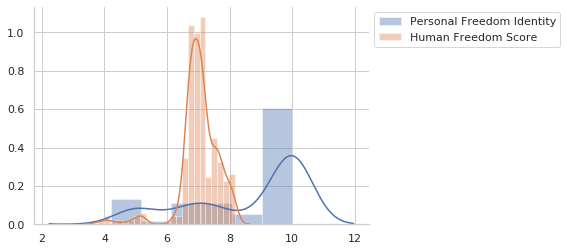

In [15]:
sns.distplot(dataset_la['pf_identity'], label='Personal Freedom Identity')
sns.distplot(dataset_la['hf_score'], label='Human Freedom Score')
plt.legend(bbox_to_anchor=(1, 1, 0, 0))
sns.despine()
plt.xlabel('')

Visualizando la distribucion de los datos, yo considero que para comparar el Puntaje de Libertad Humana(hf_score) entre paises utilizaria la media o la mediana ya que son muy similares entre si y representan a la mayoria del conjunto de datos. Por otro lado, en cambio, para comparar la Libertad Personal de Identidad(pf_identity) usaria la media.

### Media, Mediana y Desviacion Estándar 

#### Libertad Personal de Identidad

In [16]:
print('Media Mundial', dataset.pf_identity.mean())
print('Media Latino América', dataset_la.pf_identity.mean())
print('\n')
print('Mediana Mundial', dataset.pf_identity.median())
print('Mediana Latino América', dataset_la.pf_identity.median())
print('\n')
print('Desviacion estandar Mundial', dataset.pf_identity.std())
print('Desviacion estandar Latino América', dataset_la.pf_identity.std())

Media Mundial 7.280649350649351
Media Latino América 8.582170542635659


Mediana Mundial 8.8
Mediana Latino América 10.0


Desviacion estandar Mundial 3.1815770188080887
Desviacion estandar Latino América 1.875832354285877


#### Puntaje de Libertad Humana

In [17]:
print('Media Mundial', dataset.hf_score.mean())
print('Media Latino América', dataset_la.hf_score.mean())
print('\n')
print('Mediana Mundial', dataset.hf_score.median())
print('Mediana Latino América', dataset_la.hf_score.median())
print('\n')
print('Desviacion estandar Mundial', dataset.hf_score.std())
print('Desviacion estandar Latino América', dataset_la.hf_score.std())

Media Mundial 6.978214285714286
Media Latino América 7.036976744186046


Mediana Mundial 6.9
Mediana Latino América 7.02


Desviacion estandar Mundial 1.0562392335897268
Desviacion estandar Latino América 0.6348970989895226


### Calculo de la moda

#### Libertad Personal de Identidad

In [18]:
print('Moda Mundial', float(dataset.pf_identity.mode()))
print('Moda Latino América', float(dataset_la.pf_identity.mode()))

Moda Mundial 10.0
Moda Latino América 10.0


#### Puntaje de Libertad Humana

In [19]:
print('Moda Mundial', float(dataset.hf_score.mode()))
print('Moda Latino América', float(dataset_la.hf_score.mode()))

Moda Mundial 6.75
Moda Latino América 6.72


Tiene sentido calcular la moda para poder contrastarla con los otros valores calculados y tener un panorama mas completo.

### Valores faltanes

In [20]:
values = {}
for column in dataset.columns:
    na_values_w = dataset[column].isna().sum()
    na_values_la = dataset_la[column].isna().sum()
    values[column] = [na_values_w, na_values_la]
df_nan = pd.DataFrame(values, index=["Mundo", "Latino América"])
df_nan

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank
Mundo,0,0,0,0,1312,83,80,80,101,80,80,80,80,80,80,80
Latino América,0,0,0,0,200,2,2,2,12,2,2,2,2,2,2,2


Text(0.5, 1, 'Valores faltantes')

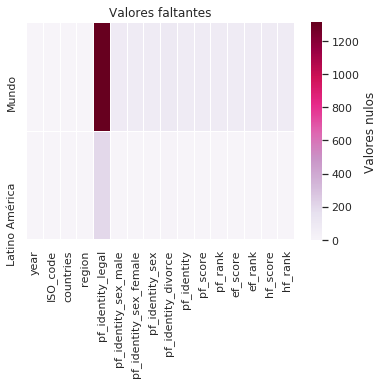

In [21]:
sns.heatmap(df_nan, linewidths=.01, cmap="PuRd", cbar_kws={'label': 'Valores nulos'})
plt.title("Valores faltantes")

Podemos observar en esta tabla la cantidad de valores faltantes en Latino América y el acumulado total en el Mundo. Una estrategia podria llegar a ser rellenar los valores faltantes de los diferentes paises segun un promedio del valor correspondiente de los paises mas allegados o de la region, teniendo en cuenta el posible error que puede acarrear esto. Otra opción es dejar los valores directamente nulos. 

### Outliers

Para tener una visualizacion rapida de los posibles outliers podemos utilizar un boxplot.
Por otro lado podemos usar el z-score, donde usualmente se realizan cortes con valores de Z +/-3, es decir hasta 3 desviaciones estandar de nuestra media. En nuestro caso tomamos el valor absoluto de estos valores, por ende serian valores tales que Z > 3.

#### Libertad Personal de Identidad

###### Global

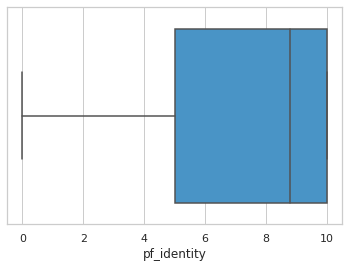

In [22]:
sns.boxplot(dataset.pf_identity, color="#3498DB")

In [23]:
zs_pf_identity_g = np.abs((dataset['pf_identity'] - dataset['pf_identity'].mean())/dataset['pf_identity'].std(ddof=0))
out_pf_identity_g = zs_pf_identity_g>3
num_out_pf_identity_g = (out_pf_identity_g).sum()
print(f'En la libertad personal de identidad podemos considerar que hay {num_out_pf_identity_g} outliers a nivel global')

En la libertad personal de identidad podemos considerar que hay 0 outliers a nivel global


###### Latino América

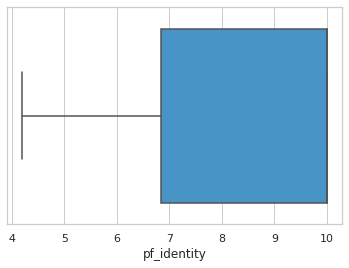

In [24]:
sns.boxplot(dataset_la.pf_identity, color="#3498DB")

In [25]:
zs_pf_identity_la = np.abs((dataset_la['pf_identity'] - dataset_la['pf_identity'].mean())/dataset_la['pf_identity'].std(ddof=0))
out_pf_identity_la = zs_pf_identity_la>3
num_out_pf_identity_la = (out_pf_identity_la).sum()
print(f'En la libertad personal de identidad podemos considerar que hay {num_out_pf_identity_la} outliers a nivel latino america')

En la libertad personal de identidad podemos considerar que hay 0 outliers a nivel latino america


#### Puntaje de Libertad Humana

###### Global

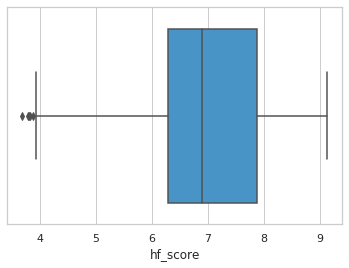

In [26]:
sns.boxplot(dataset.hf_score, color="#3498DB")

In [27]:
zs_hf_score_g = np.abs((dataset['hf_score'] - dataset['hf_score'].mean())/dataset['hf_score'].std(ddof=0))
out_hf_score_g = zs_hf_score_g>3
num_out_hf_score_g = (out_hf_score_g).sum()
print(f'En el puntaje de libertad humana podemos considerar que hay {num_out_hf_score_g} outliers a nivel global')

En el puntaje de libertad humana podemos considerar que hay 3 outliers a nivel global


In [28]:
dataset[out_hf_score_g]

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank
141,2017,SYR,Syria,Middle East & North Africa,NaN,0.0,0.0,0.0,0.0,0.0,2.53,162.0,5.05,155.0,3.79,162.0
157,2017,VEN,Venezuela,Latin America & the Caribbean,0.0,10.0,10.0,10.0,2.5,4.2,5.03,149.0,2.58,162.0,3.80,161.0
303,2016,SYR,Syria,Middle East & North Africa,NaN,0.0,0.0,0.0,0.0,0.0,2.45,161.0,4.93,159.0,3.69,162.0


###### Latino América

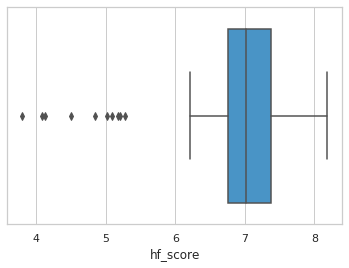

In [29]:
sns.boxplot(dataset_la.hf_score, color="#3498DB")

In [30]:
zs_hf_score_la = np.abs((dataset_la['hf_score'] - dataset_la['hf_score'].mean())/dataset_la['hf_score'].std(ddof=0))
out_hf_score_la = zs_hf_score_la>3
num_out_hf_score_la = (out_hf_score_la).sum()
print(f'En el puntaje de libertad humana podemos considerar que hay {num_out_hf_score_la} outliers a nivel latino america ')

En el puntaje de libertad humana podemos considerar que hay 7 outliers a nivel latino america 


In [31]:
dataset_la[out_hf_score_la]

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank
157,2017,VEN,Venezuela,Latin America & the Caribbean,0.0,10.0,10.0,10.0,2.5,4.2,5.03,149.0,2.58,162.0,3.80,161.0
319,2016,VEN,Venezuela,Latin America & the Caribbean,0.0,10.0,10.0,10.0,10.0,6.7,5.60,134.0,2.65,162.0,4.13,161.0
481,2015,VEN,Venezuela,Latin America & the Caribbean,0.0,10.0,10.0,10.0,10.0,6.7,5.44,138.0,2.71,159.0,4.08,158.0
643,2014,VEN,Venezuela,Latin America & the Caribbean,NaN,10.0,10.0,10.0,10.0,10.0,6.03,121.0,2.96,159.0,4.50,158.0
805,2013,VEN,Venezuela,Latin America & the Caribbean,NaN,10.0,10.0,10.0,10.0,10.0,6.67,96.0,3.01,157.0,4.84,154.0
967,2012,VEN,Venezuela,Latin America & the Caribbean,NaN,10.0,10.0,10.0,10.0,10.0,6.63,93.0,3.54,153.0,5.09,147.0
1291,2010,VEN,Venezuela,Latin America & the Caribbean,NaN,10.0,10.0,10.0,10.0,10.0,6.35,113.0,3.68,153.0,5.02,150.0


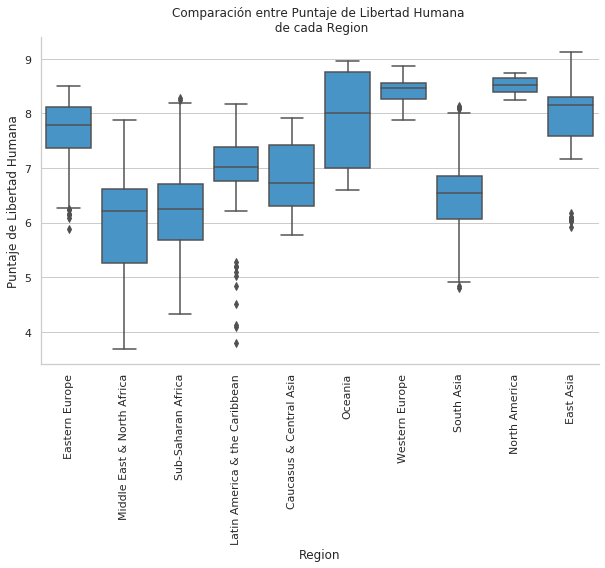

In [32]:
plt.figure(figsize=(10,6))
sns.boxplot(data=dataset,x='region', y='hf_score', color="#3498DB") 
plt.ylabel('Puntaje de Libertad Humana')
plt.xlabel('Region')
plt.title('Comparación entre Puntaje de Libertad Humana \n de cada Region')
plt.xticks(rotation=90)
sns.despine()

Viendo los resultados de los posibles outliers a nivel regional y global, considero que podemos decir que los outliers son principalmente por grupo, cuando lo analizamos a nivel regional encontramos mayor cantidad de outliers que a nivel mundial.

Los outliers a nivel Latino América no los quitaria ya que todos pertenecen al mismo pais, pero aunque sean valores extremos estos representan una realidad que no deberiamos ignorar.

## 2. Agregación de datos

1. Grafiquen la media de la variable *pf_identity* y *hf_score* a través de los años.
2. Realicen los mismos gráficos, pero separando por regiones (Cada variable en un gráfico distinto, sino no se ve nada). ¿La tendencia observada, es la misma que si no dividimos por regiones?
3. Si lo consideran necesario, grafiquen algunos países de Latinoamerica para tratar de explicar la tendencia de la variable *pf_identity* en la región. ¿Cómo seleccionarion los países relevantes a esa tendencia?

Pista: hay gráficos de seaborn que permiten generar visualizaciones para cada valor de una variable categórica, en este caso, las distintas regiones.

Sólo por curiosidad, graficar la tendencia de *hf_score* y *ef_score* a través de los años. ¿Tienen alguna hipótesis para este comportamiento?

### Media de la variables a través de los años

#### Global

Text(0.5, 0, 'Año')

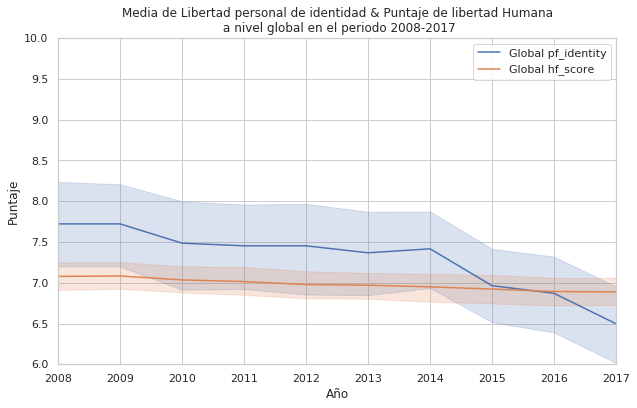

In [33]:
plt.figure(figsize=(10,6))
plt.title('Media de Libertad personal de identidad & Puntaje de libertad Humana\n a nivel global en el periodo 2008-2017')
plt.xlim(2008,2017)
plt.ylim(6,10)
sns.lineplot(dataset.year, dataset.pf_identity, label="Global pf_identity",)
sns.lineplot(dataset.year, dataset.hf_score, label="Global hf_score")
plt.legend(bbox_to_anchor=(1, 1, 0, 0))
plt.ylabel('Puntaje')
plt.xlabel('Año')

#### Por regiones

##### Libertad personal de identidad 

Text(0.5, 0, 'Año')

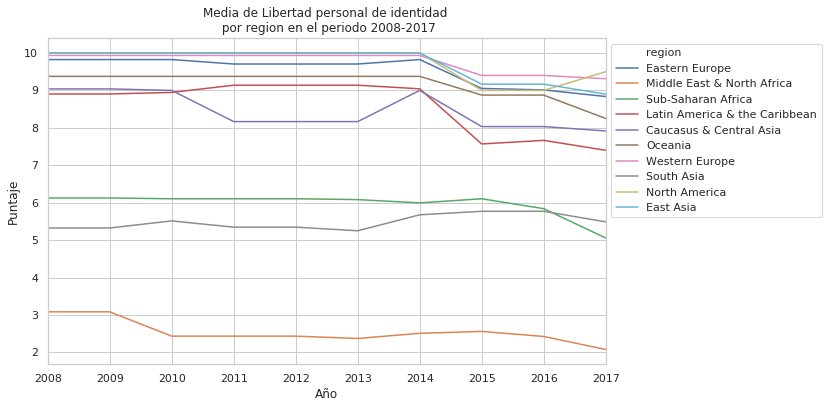

In [34]:
plt.figure(figsize=(10,6))
plt.title('Media de Libertad personal de identidad \n por region en el periodo 2008-2017')
plt.xlim(2008,2017)
sns.lineplot(dataset.year, dataset.pf_identity, hue=dataset.region, ci=None)
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Puntaje')
plt.xlabel('Año')

Text(0.5, 0.98, 'Media de Libertad personal de identidad \n por region en el periodo 2008-2017')

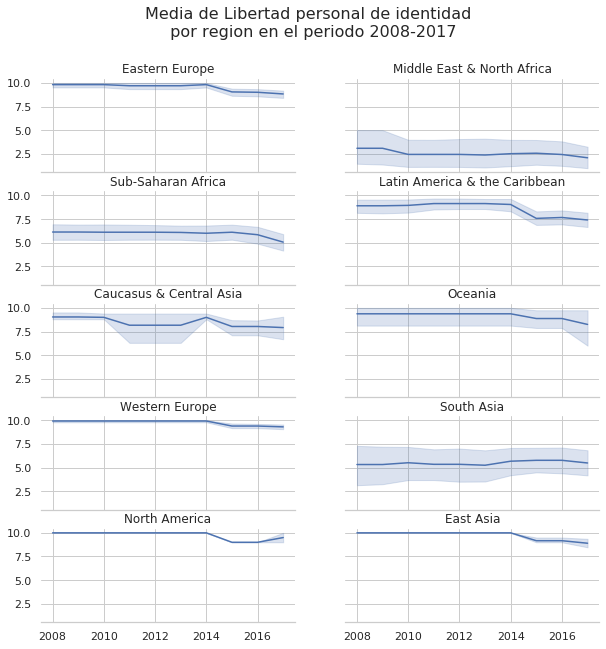

In [35]:
fig, axes = plt.subplots(5, 2, figsize=(10, 10), sharex=True, sharey=True)
sns.despine(left=True)

row = 0
column = 0
regions = dataset.region.unique()

for region in regions:
    sns.lineplot(dataset.year, dataset[dataset.region == str(region)].pf_identity, ax=axes[column, row])
    axes[column, row].title.set_text(str(region))
    axes[column, row].set_ylabel('')
    axes[column, row].set_xlabel('')
    if row == 1:
        row = 0
        column+=1
    else:
        row = 1
fig.suptitle('Media de Libertad personal de identidad \n por region en el periodo 2008-2017', fontsize=16)

##### Puntaje de libertad Humana

Text(0.5, 0, 'Año')

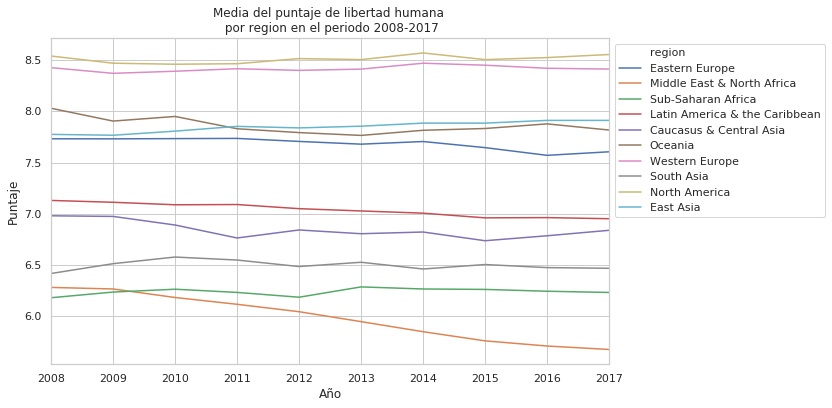

In [36]:
plt.figure(figsize=(10,6))
plt.title('Media del puntaje de libertad humana \n por region en el periodo 2008-2017')
plt.xlim(2008,2017)
sns.lineplot(dataset.year, dataset.hf_score, hue=dataset.region, ci=None)
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Puntaje')
plt.xlabel('Año')

Text(0.5, 0.98, 'Media del puntaje de libertad humana \n por region en el periodo 2008-2017')

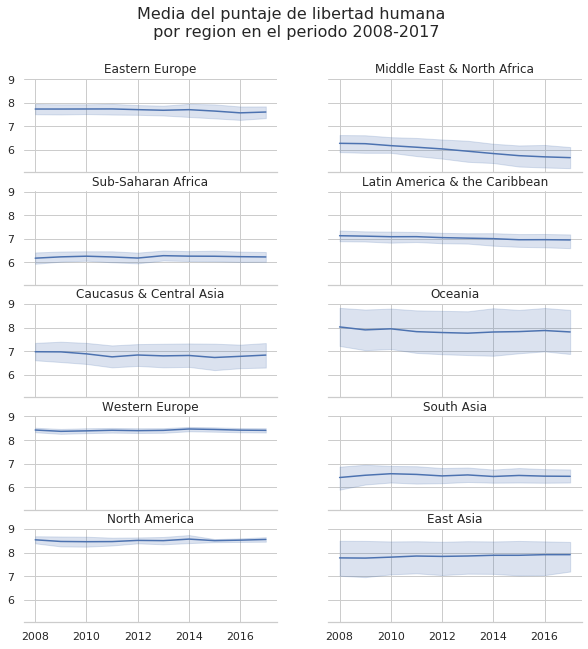

In [37]:
fig, axes = plt.subplots(5, 2, figsize=(10, 10), sharex=True, sharey=True)
sns.despine(left=True)

row = 0
column = 0
regions = dataset.region.unique()

for region in regions:
    sns.lineplot(dataset.year, dataset[dataset.region == str(region)].hf_score, ax=axes[column, row])
    axes[column, row].title.set_text(str(region))
    axes[column, row].set_ylabel('')
    axes[column, row].set_xlabel('')
    if row == 1:
        row = 0
        column+=1
    else:
        row = 1
fig.suptitle('Media del puntaje de libertad humana \n por region en el periodo 2008-2017', fontsize=16)

Al comparar los gráficos podemos observar que la tendencia mundial en la Libertad personal de identidad representa a la mayoria de las tendencias a nivel regional, un gran conjunto de estas tienden a la baja en los ultimos años.
Por otro lado, la tendencia mundial del Puntaje de libertad humana tambien representa a la gran mayoria de las tendencias regionales que estan bastantes estables a lo largo de los años. 

#### Libertad personal de identidad en Latino América

Text(0.5, 0, 'Año')

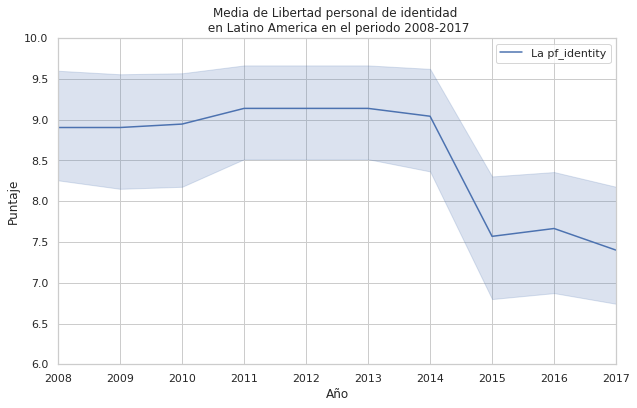

In [38]:
plt.figure(figsize=(10,6))
plt.title('Media de Libertad personal de identidad \n en Latino America en el periodo 2008-2017')
plt.xlim(2008,2017)
plt.ylim(6,10)
sns.lineplot(dataset.year, dataset[dataset.region == 'Latin America & the Caribbean'].pf_identity, label="La pf_identity",)
plt.ylabel('Puntaje')
plt.xlabel('Año')

In [39]:
represent_countries = []

# Get countries with max value
countries = dataset_la.countries.unique()
pf_identity_max = dataset_la.pf_identity.max()
for countrie in countries:
    mean = dataset_la[dataset_la.countries == countrie].pf_identity.mean()
    if(mean == pf_identity_max):
        represent_countries.append(countrie)   

# Small Z score, get countries near mean
zs_pf_identity_la = np.abs((dataset_la['pf_identity'] - dataset_la['pf_identity'].mean())/dataset_la['pf_identity'].std(ddof=0))
close_mean_pf_identity_la = zs_pf_identity_la<0.5
mean_countries = dataset_la[close_mean_pf_identity_la].countries.unique()
for countrie in mean_countries:
    represent_countries.append(countrie)

# Get countries with min value
pf_identity_min = dataset_la.pf_identity.min()
min_countries = dataset_la[dataset_la.pf_identity == pf_identity_min].countries.unique()
for countrie in min_countries:
    represent_countries.append(countrie)

print("Paises que representan a Latino America: ")
for countrie in represent_countries:
    print(countrie)

Paises que representan a Latino America: 
Argentina
Bahamas
Bolivia
Colombia
Suriname
Uruguay
Ecuador
Panama
Peru
Guatemala
Jamaica
Venezuela


El criterio de seleccion de los países fue, aquellos que su media de pf_identity sea igual al valor máximo de la variable, aquellos que esten mas próximos a la media de pf_identity y por ultimo, aquellos que que tengan los valores mínimos de la variable pf_identity. Esto nos da como resultado la lista previamente visualizada de 12 países.

Text(0.5, 0, 'Año')

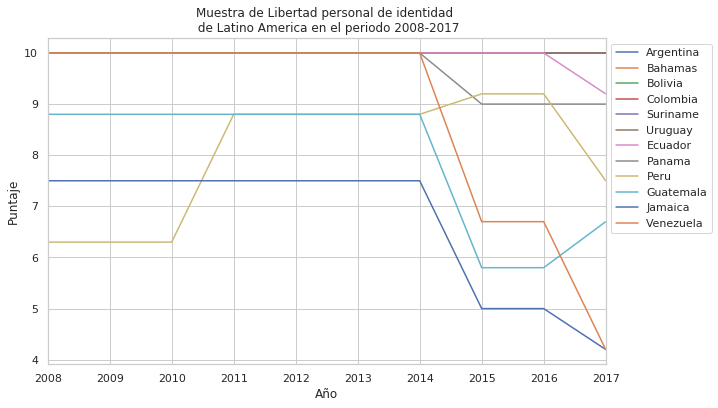

In [40]:
plt.figure(figsize=(10,6))
plt.title('Muestra de Libertad personal de identidad \n de Latino America en el periodo 2008-2017')
plt.xlim(2008,2017)
for countrie in represent_countries:
    sns.lineplot(dataset.year, dataset[dataset.countries == str(countrie)].pf_identity, label=str(countrie), ci=None)
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Puntaje')
plt.xlabel('Año')

Text(0.5, 0.98, 'Muestra de Libertad personal de identidad \n de Latino America en el periodo 2008-2017')

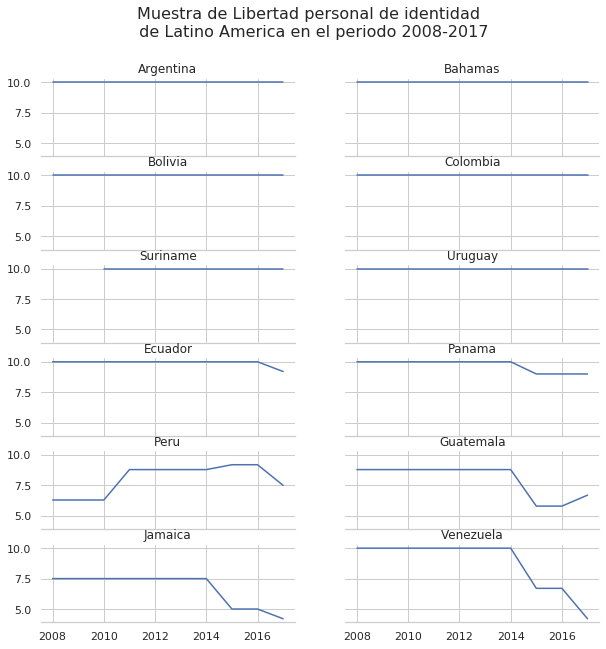

In [41]:
fig, axes = plt.subplots(6, 2, figsize=(10, 10), sharex=True, sharey=True)
sns.despine(left=True)

row = 0
column = 0

for countrie in represent_countries:
    sns.lineplot(dataset.year, dataset[dataset.countries == str(countrie)].pf_identity, ax=axes[column, row])
    axes[column, row].title.set_text(str(countrie))
    axes[column, row].set_ylabel('')
    axes[column, row].set_xlabel('')
    if row == 1:
        row = 0
        column+=1
    else:
        row = 1
fig.suptitle('Muestra de Libertad personal de identidad \n de Latino America en el periodo 2008-2017', fontsize=16)

#### Puntaje de libertad Económica & Puntaje de libertad Humana

Text(0.5, 0, 'Año')

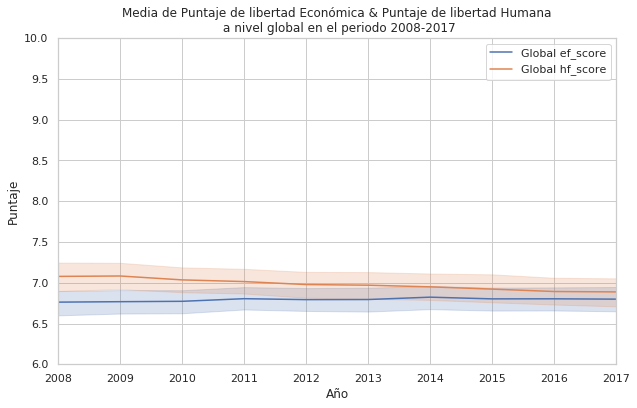

In [42]:
plt.figure(figsize=(10,6))
plt.title('Media de Puntaje de libertad Económica & Puntaje de libertad Humana\n a nivel global en el periodo 2008-2017')
plt.xlim(2008,2017)
plt.ylim(6,10)
sns.lineplot(dataset.year, dataset.ef_score, label="Global ef_score",)
sns.lineplot(dataset.year, dataset.hf_score, label="Global hf_score")
plt.legend(bbox_to_anchor=(1, 1, 0, 0))
plt.ylabel('Puntaje')
plt.xlabel('Año')

---Insertar Hipotesis--- 

## 3. Distribuciones
  1. Graficar en un mismo histograma la distribución de la variable *pf_identity* en global, y en Latinoamérica y el caribe. Repetir para la variable *hf_score*. ¿Visualmente, a qué tipo de distribución corresponde cada variable? ¿Es correcto utilizar todos el conjunto de valores disponibles para esa region en estos gráficos?


Text(0.5, 0, '')

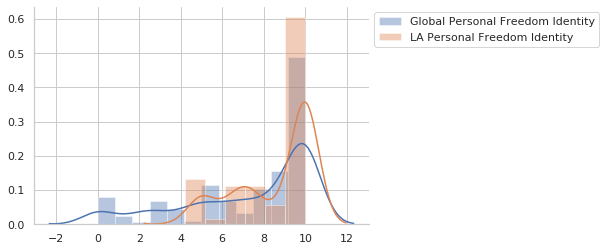

In [43]:
sns.distplot(dataset.pf_identity, label='Global Personal Freedom Identity')
sns.distplot(dataset_la.pf_identity, label='LA Personal Freedom Identity')
plt.legend(bbox_to_anchor=(1, 1, 0, 0))
sns.despine()
plt.xlabel('')

Text(0.5, 0, '')

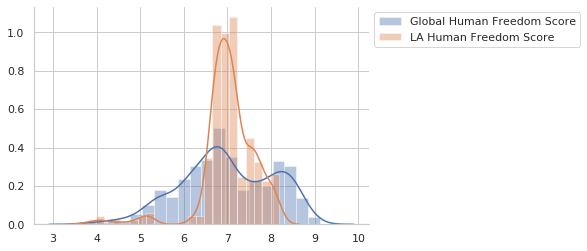

In [44]:
sns.distplot(dataset.hf_score, label='Global Human Freedom Score')
sns.distplot(dataset_la.hf_score, label='LA Human Freedom Score')
plt.legend(bbox_to_anchor=(1, 1, 0, 0))
sns.despine()
plt.xlabel('')

---Insertar respuestas---

## 4. Correlaciones y Relaciones

En este ejercicio queremos responder a las preguntas

* Las libertades personales y económicas, ¿van siempre de la mano?
* ¿Cómo se relacionan ambas con las libertades respectivas a las relaciones personales?

Para ello, analizaremos las correlaciones entre las variables pf_identity, pf_score y ef_score. 

Como pf_indentity contribuye al cálculo de pf_score esperamos hallar algún grado de correlación. Lo contrario podría ocurrir con ef_score. 

1. ¿Qué conclusiones puede sacar de un gráfico pairplot de estas tres variables? ¿Es adecuado para los valores de pf_identity? ¿Por qué?
2. Graficar la correlación (visual) entre pf_identity y pf_score; y entre pf_identity y ef_score. Analizar el resultado, ¿se pueden sacar conclusiones? Tengan en cuenta que como pf_identity es el resultado de un promedio, sólo toma algunos valores. Es, en la práctica, discreta, y eso afecta al tipo de gráfico que podemos usar.
3. Convertir estas variables en categóricas, es decir, a partir de pf_indentity generar otra variable pf_identity_segment que tome los valores `high`, `medium` y `low`. Pueden hacerlo con una función escrita por ustedes, o usando alguna función de pandas como `pandas.cut` o `pandas.dcut`. Repetir para ef_score y pf_score. El criterio para decidir qué intervalos de valores corresponden a cada categoría tienen que decidirlo ustedes, pueden usar los estadísticos mediana y los cuartiles.
4. Graficar la correlación (visual) entre estas tres variables categoricas usando gráficos de calor (heatmaps). Note: van a necesitar 3 gráficos distintos, porque en cada uno podemos incluir sólo 2 variables.



#### Correlaciones entre libertades  de identidad, personales y economicas

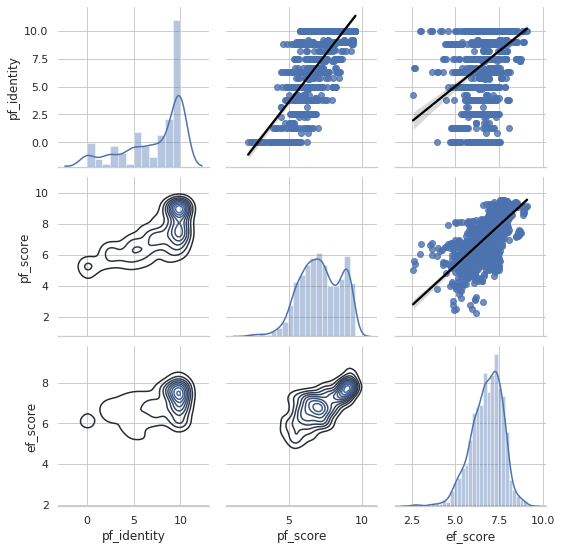

In [45]:
g = sns.PairGrid(dataset, vars=["pf_identity", "pf_score", "ef_score"])
g = g.map_lower(sns.kdeplot)
g = g.map_diag(sns.distplot)
g = g.map_upper(sns.regplot, line_kws={'color':'black'})
sns.despine(left=True)

En primer lugar observando el garfico podemos observar la distribucion de los datos en la diagonal, luego interpretamos algunas cosas a partir de las relaciones entre las variables.
Por un lado, vemos que a mayor libertad economica tenemos un crecimiento en las libertades de identidad y en el puntaje de libertad personal.
A su vez, como era de esperar, a medida que crece la libertad de identidad tambien crece el puntaje de libertad personal.

¿Es adecuado para los valores de pf_identity? ¿Por qué? RESPONDER

#### Relacion entre Libertad de identidad y Libertad personal

Text(0.5, 0, 'Libertad de identidad')

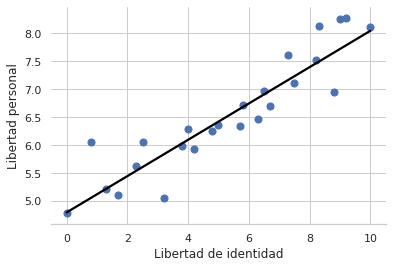

In [46]:
sns.regplot(dataset.pf_identity, dataset.pf_score, x_estimator=np.mean, line_kws={'color':'black'}, ci=None)
sns.despine(left=True)
plt.ylabel('Libertad personal')
plt.xlabel('Libertad de identidad')

In [47]:
np.corrcoef(dataset.pf_identity.dropna(), dataset.pf_score.dropna())

array([[1.        , 0.74220858],
       [0.74220858, 1.        ]])

Observando el gráfico vemos que hay una correlacion relativamente marcada entre ambas variables con una covarianza de valor 0.74. 

#### Relacion entre Libertad de identidad y Libertad económica

Text(0.5, 0, 'Libertad de identidad')

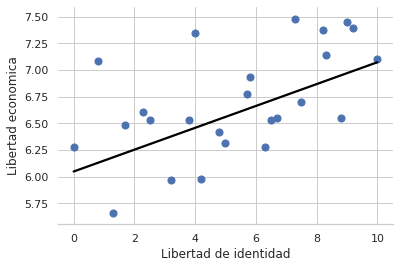

In [48]:
sns.regplot(dataset.pf_identity, dataset.ef_score, x_estimator=np.mean, line_kws={'color':'black'}, ci=None)
sns.despine(left=True)
plt.ylabel('Libertad economica')
plt.xlabel('Libertad de identidad')

In [49]:
np.corrcoef(dataset.pf_identity.dropna(), dataset.ef_score.dropna())

array([[1.        , 0.35915104],
       [0.35915104, 1.        ]])

Observando el gráfico no vemos demasiada correlación entre las variables, a su vez esto se ve reflejado en el valor de su covarianza siendo este de 0.35.

#### Correlacion de las variables en formato categórico

Dividimos las variables pf_identity, pf_score y ef_score en tres partes iguales con valores correspondientes a 'high', 'medium' y 'low'.

In [50]:
pf_identity_segment=pd.cut(dataset.pf_identity, 3, labels=["low", "medium", "high"]) 
pf_score_segment=pd.cut(dataset.pf_score, 3, labels=["low", "medium", "high"]) 
ef_score_segment=pd.cut(dataset.ef_score, 3, labels=["low", "medium", "high"]) 
dataset['pf_identity_segment'] = pf_identity_segment
dataset['pf_score_segment'] = pf_score_segment
dataset['ef_score_segment'] = ef_score_segment
dataset.sample(5)

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank,pf_identity_segment,pf_score_segment,ef_score_segment
949,2012,SWE,Sweden,Western Europe,NaN,10.0,10.0,10.0,7.5,8.8,9.32,4.0,7.68,22.0,8.50,11.0,high,high,high
1138,2010,ARM,Armenia,Caucasus & Central Asia,NaN,10.0,10.0,10.0,7.5,8.8,7.25,74.0,7.56,27.0,7.41,54.0,high,high,high
399,2015,JPN,Japan,East Asia,7.0,10.0,10.0,10.0,10.0,9.0,8.75,29.0,7.85,16.0,8.30,24.0,high,high,high
89,2017,LUX,Luxembourg,Western Europe,7.0,10.0,10.0,10.0,10.0,9.0,9.26,5.0,7.86,17.0,8.56,6.0,high,high,high
867,2012,GRC,Greece,Eastern Europe,NaN,10.0,10.0,10.0,5.0,7.5,8.34,42.0,6.83,81.0,7.59,47.0,high,high,medium


##### Mapa de calor entre Libertad de identidad y Libertad personal

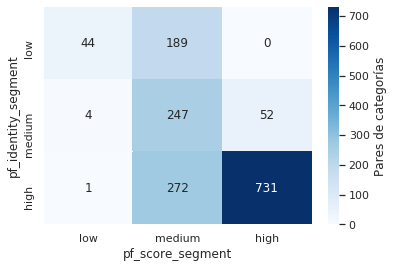

In [51]:
heat_pfi_pfs = pd.crosstab(dataset.pf_identity_segment, dataset.pf_score_segment)
sns.heatmap(heat_pfi_pfs, annot=True, fmt="d", cmap="Blues", cbar_kws={'label': 'Pares de categorías'})

Podemos observar que tenemos una fuerte relacion entre valores altos de las variables pf_identity y pf_score.

##### Mapa de calor entre  Libertad de identidad y Libertad económica

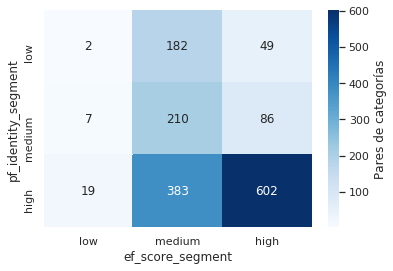

In [52]:
heat_pfi_efs = pd.crosstab(dataset.pf_identity_segment, dataset.ef_score_segment)
sns.heatmap(heat_pfi_efs, annot=True, fmt="d", cmap="Blues", cbar_kws={'label': 'Pares de categorías'})

Podemos observar que tenemos una fuerte relacion entre valores altos de las variables pf_identity y ef_score, a su vez se aprecia una relacion moderada entre valores medios de ef_score y valores altos de pf_identity.

##### Mapa de calor entre  Libertad personal y Libertad económica

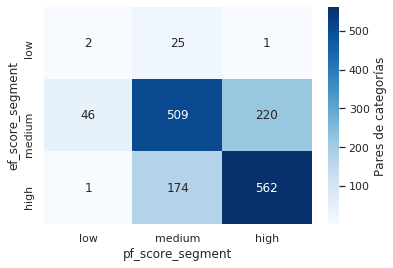

In [53]:
heat_efs_pfs = pd.crosstab(dataset.ef_score_segment, dataset.pf_score_segment)
sns.heatmap(heat_efs_pfs, annot=True, fmt="d", cmap="Blues", cbar_kws={'label': 'Pares de categorías'})

Podemos observar que tenemos una fuerte relacion entre valores altos y medios de las variables pf_score y ef_score.

# Parte 2

Luego del segundo fin de semana de clase, podemos revisitar nuestro trabajo anterior y completarlo respondiendo a las siguientes preguntas:

## 3. Distribuciones

2. Realizar una prueba de Kolmogorov-Smirnov para comprobar analíticamente si estas variables responden la distribución propuesta en el ejercicio anterior. Hint: podés usar https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kstest.html, pero hay que tener en cuenta que si la distribución es "norm", entonces va a comparar los datos con una distribución normal con media 0 y desviación estándar 1. Se puede utilizar la distribución sobre todos los datos o sólo sobre Latinoamérica.

#### KS test

##### Mundial

##### Libertad de identidad

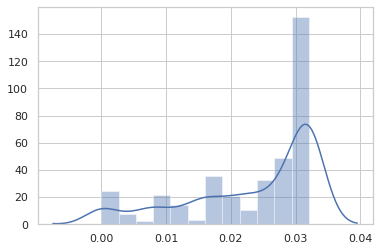

In [61]:
pf_identity = np.array(dataset.pf_identity.dropna())
normalized_global_pfi = preprocessing.normalize([pf_identity])
sns.distplot(normalized_global_pfi)

In [62]:
stats.kstest(normalized_global_pfi, 'norm')

KstestResult(statistic=0.5127931937829716, pvalue=0.9744136124340568)

##### Libertad económica

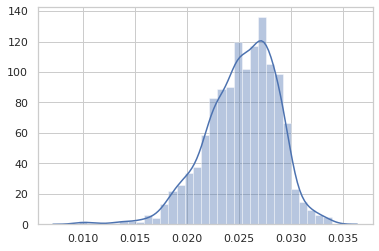

In [63]:
ef_score = np.array(dataset.ef_score.dropna())
normalized_global_efs = preprocessing.normalize([ef_score])
sns.distplot(normalized_global_efs)

In [64]:
stats.kstest(normalized_global_efs, 'norm')

KstestResult(statistic=0.5135111236187266, pvalue=0.9729777527625467)

##### Libertad personal

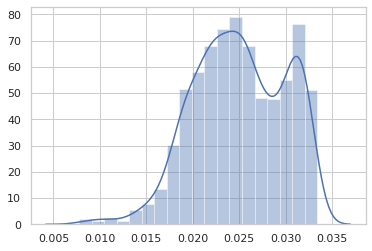

In [65]:
pf_score = np.array(dataset.pf_score.dropna())
normalized_global_pfs = preprocessing.normalize([pf_score])
sns.distplot(normalized_global_pfs)

In [66]:
stats.kstest(normalized_global_pfs, 'norm')

KstestResult(statistic=0.5133155493073426, pvalue=0.9733689013853148)

##### Latino América

##### Libertad de identidad

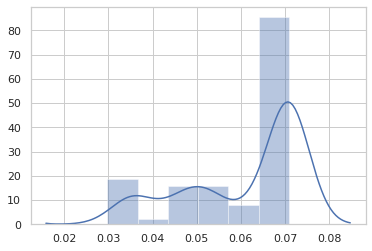

In [67]:
pf_identity_la = np.array(dataset_la.pf_identity.dropna())
normalized_la_pfi = preprocessing.normalize([pf_identity_la])
sns.distplot(normalized_la_pfi)

In [68]:
stats.kstest(normalized_la_pfi, 'norm')

KstestResult(statistic=0.5282516691791451, pvalue=0.9434966616417098)

##### Libertad económica

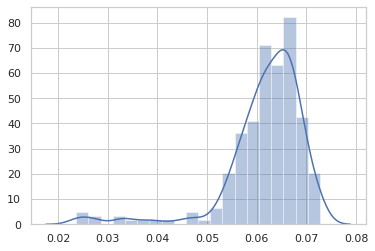

In [69]:
ef_score_la = np.array(dataset_la.ef_score.dropna())
normalized_la_efs = preprocessing.normalize([ef_score_la])
sns.distplot(normalized_la_efs)

In [70]:
stats.kstest(normalized_la_efs, 'norm')

KstestResult(statistic=0.5290047024812138, pvalue=0.9419905950375724)

##### Libertad personal

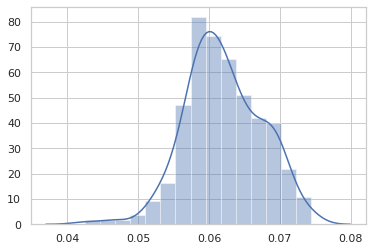

In [71]:
pf_score_la = np.array(dataset_la.pf_score.dropna())
normalized_la_pfs = preprocessing.normalize([pf_score_la])
sns.distplot(normalized_la_pfs)

In [72]:
stats.kstest(normalized_la_pfs, 'norm')

KstestResult(statistic=0.5296739612126932, pvalue=0.9406520775746137)

## 4. Correlaciones

3. Calcular algún coeficiente de correlación adecuado entre los dos pares de variables, dependiendo de la cantidad de datos, el tipo de datos y la distribución de los mismo. Algunas opciones son: coeficiente de pearson, coeficiente de spearman, coeficientes de tau y de kendall. Interpretar los resultados y justificar si las variables están correlacionadas o no. 
4. [Opcional] Analizar la correlación entre la region y el pf_score (y/o el ef_score); y entre la region y el pf_identity. Considerar que como la variable *region* es ordinal, debe utilizarse algún tipo de test. Explicar cuáles son los requisitos necesarios para la aplicación de ese test. (Si no se cumplieran, se pueden agregar algunos datos para generar más registros). Genere nuevas variables categóricas ordinales para calcular la correlación Tau de Kendal y genere una tabla de contingencia con esas nuevas variables.

#### Coeficiente de correlacion de Pearson

##### Libertad de identidad y Libertad personal

In [73]:
np.corrcoef(dataset.pf_identity.dropna(), dataset.pf_score.dropna())

array([[1.        , 0.74220858],
       [0.74220858, 1.        ]])

##### Libertad de identidad y Libertad económica

In [74]:
np.corrcoef(dataset.pf_identity.dropna(), dataset.ef_score.dropna())

array([[1.        , 0.35915104],
       [0.35915104, 1.        ]])

##### Libertad personal y Libertad económica

In [75]:
np.corrcoef(dataset.ef_score.dropna(), dataset.pf_score.dropna())

array([[1.        , 0.67366293],
       [0.67366293, 1.        ]])

Además de completar estos puntos faltantes, luego de haber visitado los conceptos de percepción visual y comunicación efectiva, están en condiciones de reveer los gráficos realizados y evaluar si pueden ser mejorados. Para ello, puede hacerse las siguientes preguntas:

* ¿Están utilizando el tipo de gráfico adecuado para cada tipo de variable?
* Los gráficos, ¿son legibles?
* Los gráficos generados, ¿responden a las preguntas mostrando un patrón claro? En caso de que no, ¿podemos filtrar los datos para que el patrón sea más evidente? ¿o agruparlos de manera distinta? ¿o cambiar el tipo de gráfico?